# Prediksi Harga Jual Tanah dan Bangunan
## Menggunakan Ensemble Machine Learning

Notebook ini mengimplementasikan model machine learning untuk memprediksi:
1. **Harga Jual Tanah** - Menggunakan fitur lokasi, luas, dan karakteristik tanah
2. **Harga Jual Bangunan** - Menggunakan fitur lokasi, luas, kondisi, dan fasilitas bangunan

### Algoritma yang Digunakan:
- **XGBoost** (Extreme Gradient Boosting)
- **Random Forest**
- **CatBoost** (Categorical Boosting)
- **Voting Regressor** (Ensemble dari ketiga model)

### Dataset:
- `Jual_Tanah_Prediksi.csv` - Data training untuk harga jual tanah
- `Jual_Bangunan_Prediksi.csv` - Data training untuk harga jual bangunan

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully
Pandas version: 2.3.0
NumPy version: 2.2.6


## 2. Load Dataset

In [2]:
# Load datasets
tanah_df = pd.read_csv('../data/raw/Jual_Tanah_Prediksi.csv')
bangunan_df = pd.read_csv('../data/raw/Jual_Bangunan_Prediksi.csv')

print("📊 Dataset Tanah:")
print(f"   Jumlah baris: {len(tanah_df)}")
print(f"   Jumlah kolom: {len(tanah_df.columns)}")
print(f"   Kolom: {list(tanah_df.columns)}")
print()
print("🏢 Dataset Bangunan:")
print(f"   Jumlah baris: {len(bangunan_df)}")
print(f"   Jumlah kolom: {len(bangunan_df.columns)}")
print(f"   Kolom: {list(bangunan_df.columns)}")

📊 Dataset Tanah:
   Jumlah baris: 1000
   Jumlah kolom: 9
   Kolom: ['Kecamatan', 'Sertifikat', 'Luas Tanah (M²)', 'Jenis Zona', 'Aksesibilitas', 'Tingkat Keamanan', 'Kepadatan_Penduduk', 'Jarak ke Pusat Kota (km)', 'Nilai Jual Tanah (Rp)']

🏢 Dataset Bangunan:
   Jumlah baris: 1000
   Jumlah kolom: 15
   Kolom: ['Kecamatan', 'Luas Tanah (m²)', 'Luas Bangunan (m²)', 'Jumlah Lantai', 'Kondisi Properti', 'Kondisi Perabotan', 'Sertifikat', 'Daya Listrik (watt)', 'Hook', 'NJOP (Rp/m²)', 'Jenis Zona', 'Aksesibilitas', 'Tingkat Keamanan', 'Usia Bangunan (tahun)', 'Nilai Jual Bangunan (Rp)']


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Display first few rows
print("📋 Sample Data Tanah:")
display(tanah_df.head())

print("\n📋 Sample Data Bangunan:")
display(bangunan_df.head())

📋 Sample Data Tanah:


,Kecamatan,Sertifikat,Luas Tanah (M²),Jenis Zona,Aksesibilitas,Tingkat Keamanan,Kepadatan_Penduduk,Jarak ke Pusat Kota (km),Nilai Jual Tanah (Rp)
0,Kenjeran,Lainnya,407.00,Perumahan,Buruk,rendah,181325,8.12,7.578340e+08
1,Rungkut,HGB,1840.00,Perumahan,Buruk,tinggi,123757,19.06,4.327680e+09
2,Gunung Anyar,HGB,1125.00,Komersial,Baik,rendah,62482,14.91,2.094750e+09
3,Pakal,HGB,682.97,Industri,Baik,tinggi,59971,12.37,8.132176e+08
4,Krembangan,HGB,2134.79,Industri,Baik,rendah,109027,3.96,8.046495e+09



📋 Sample Data Bangunan:


,Kecamatan,Luas Tanah (m²),Luas Bangunan (m²),Jumlah Lantai,Kondisi Properti,Kondisi Perabotan,Sertifikat,Daya Listrik (watt),Hook,NJOP (Rp/m²),Jenis Zona,Aksesibilitas,Tingkat Keamanan,Usia Bangunan (tahun),Nilai Jual Bangunan (Rp)
0,Asemrowo,549,287,2,Baru,Furnished,AJB,4400,Ya,189440,Campuran,Dekat Sekolah,5,14,54369280
1,Asemrowo,452,533,2,Butuh Renovasi,Furnished,SHM,6600,Tidak,183573,Komersial,Dekat Sekolah,4,11,97844409
2,Asemrowo,412,418,1,Butuh Renovasi,Unfurnished,SHM,6600,Tidak,183705,Perumahan,Dekat Jalan Raya,4,29,76788690
3,Asemrowo,517,555,2,Baru,Semi-Furnished,SHM,5500,Ya,199049,Perumahan,Dekat Jalan Raya,4,15,110472195
4,Asemrowo,503,54,3,Baru,Unfurnished,SHM,1300,Tidak,166412,Campuran,Dekat Jalan Raya,3,23,8986248


In [4]:
# Check for missing values
print("🔍 Missing Values - Tanah:")
print(tanah_df.isnull().sum())
print(f"\nTotal missing: {tanah_df.isnull().sum().sum()}")

print("\n🔍 Missing Values - Bangunan:")
print(bangunan_df.isnull().sum())
print(f"\nTotal missing: {bangunan_df.isnull().sum().sum()}")

🔍 Missing Values - Tanah:
Kecamatan                   0
Sertifikat                  0
Luas Tanah (M²)             0
Jenis Zona                  0
Aksesibilitas               0
Tingkat Keamanan            0
Kepadatan_Penduduk          0
Jarak ke Pusat Kota (km)    0
Nilai Jual Tanah (Rp)       0
dtype: int64

Total missing: 0

🔍 Missing Values - Bangunan:
Kecamatan                   0
Luas Tanah (m²)             0
Luas Bangunan (m²)          0
Jumlah Lantai               0
Kondisi Properti            0
Kondisi Perabotan           0
Sertifikat                  0
Daya Listrik (watt)         0
Hook                        0
NJOP (Rp/m²)                0
Jenis Zona                  0
Aksesibilitas               0
Tingkat Keamanan            0
Usia Bangunan (tahun)       0
Nilai Jual Bangunan (Rp)    0
dtype: int64

Total missing: 0


In [5]:
# Statistical summary
print("📊 Statistical Summary - Tanah:")
display(tanah_df.describe())

print("\n📊 Statistical Summary - Bangunan:")
display(bangunan_df.describe())

📊 Statistical Summary - Tanah:


,Luas Tanah (M²),Kepadatan_Penduduk,Jarak ke Pusat Kota (km),Nilai Jual Tanah (Rp)
count,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,4454.953850,92704.053000,10.314810,1.297255e+10
std,5478.233813,44841.473049,5.550762,2.270234e+10
min,1.000000,41289.000000,1.090000,5.625000e+06
25%,874.210000,59971.000000,5.485000,2.206598e+09
50%,3572.425000,75315.000000,10.440000,8.112325e+09
75%,6946.055000,110557.000000,15.137500,1.754420e+10
max,60000.000000,214966.000000,19.990000,4.065239e+11



📊 Statistical Summary - Bangunan:


,Luas Tanah (m²),Luas Bangunan (m²),Jumlah Lantai,Daya Listrik (watt),NJOP (Rp/m²),Tingkat Keamanan,Usia Bangunan (tahun),Nilai Jual Bangunan (Rp)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,312.527000,218.687000,1.985000,2672.000000,212058.171000,4.376000,14.945000,4.707573e+07
std,163.198569,141.124325,0.812056,1550.290102,37277.333539,0.896341,8.888925,3.317915e+07
min,40.000000,30.000000,1.000000,900.000000,130462.000000,1.000000,0.000000,4.847271e+06
25%,177.000000,104.750000,1.000000,1300.000000,185726.250000,4.000000,7.000000,2.161648e+07
50%,294.000000,192.000000,2.000000,2200.000000,208831.000000,5.000000,14.000000,3.995559e+07
75%,459.500000,300.000000,3.000000,4400.000000,231183.000000,5.000000,23.000000,6.327892e+07
max,600.000000,692.000000,3.000000,6600.000000,364251.000000,5.000000,30.000000,1.795705e+08


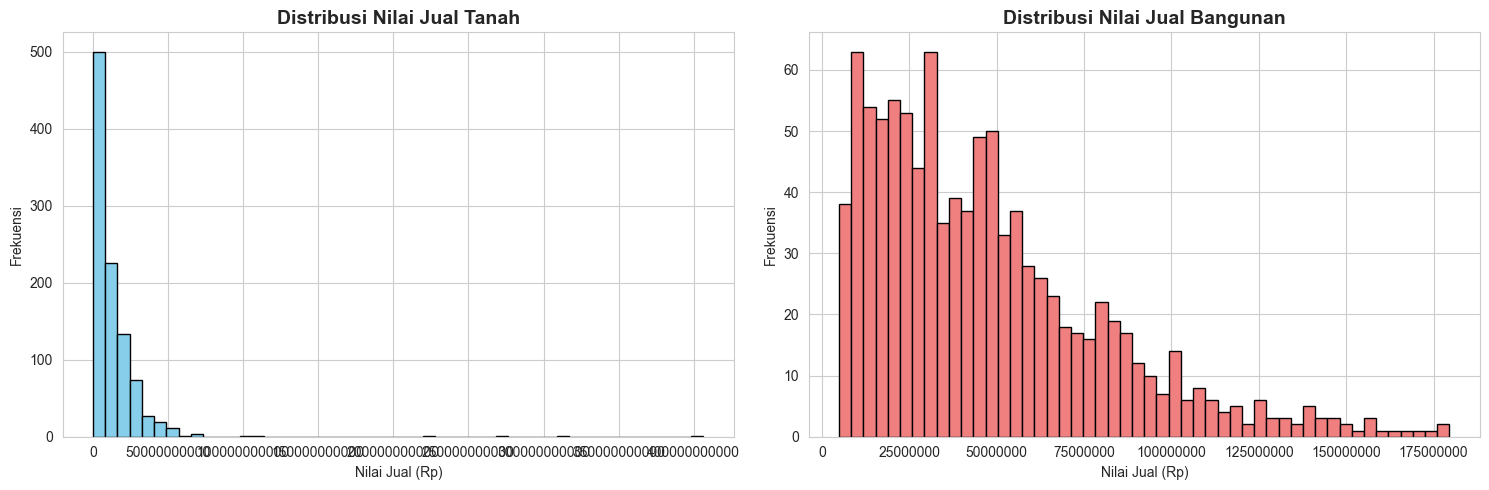


📈 Statistik Nilai Jual Tanah:
   Mean: Rp 12,972,549,202
   Median: Rp 8,112,324,959
   Min: Rp 5,625,000
   Max: Rp 406,523,895,000

📈 Statistik Nilai Jual Bangunan:
   Mean: Rp 47,075,728
   Median: Rp 39,955,590
   Min: Rp 4,847,271
   Max: Rp 179,570,540


In [6]:
# Distribution of target variable (Nilai Jual Tanah)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Tanah
axes[0].hist(tanah_df['Nilai Jual Tanah (Rp)'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribusi Nilai Jual Tanah', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nilai Jual (Rp)')
axes[0].set_ylabel('Frekuensi')
axes[0].ticklabel_format(style='plain', axis='x')

# Bangunan
axes[1].hist(bangunan_df['Nilai Jual Bangunan (Rp)'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribusi Nilai Jual Bangunan', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nilai Jual (Rp)')
axes[1].set_ylabel('Frekuensi')
axes[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

print(f"\n📈 Statistik Nilai Jual Tanah:")
print(f"   Mean: Rp {tanah_df['Nilai Jual Tanah (Rp)'].mean():,.0f}")
print(f"   Median: Rp {tanah_df['Nilai Jual Tanah (Rp)'].median():,.0f}")
print(f"   Min: Rp {tanah_df['Nilai Jual Tanah (Rp)'].min():,.0f}")
print(f"   Max: Rp {tanah_df['Nilai Jual Tanah (Rp)'].max():,.0f}")

print(f"\n📈 Statistik Nilai Jual Bangunan:")
print(f"   Mean: Rp {bangunan_df['Nilai Jual Bangunan (Rp)'].mean():,.0f}")
print(f"   Median: Rp {bangunan_df['Nilai Jual Bangunan (Rp)'].median():,.0f}")
print(f"   Min: Rp {bangunan_df['Nilai Jual Bangunan (Rp)'].min():,.0f}")
print(f"   Max: Rp {bangunan_df['Nilai Jual Bangunan (Rp)'].max():,.0f}")

## 4. Data Preprocessing

In [7]:
def preprocess_tanah_data(df):
    """
    Preprocessing data tanah:
    - Encode categorical variables
    - Handle missing values
    - Feature engineering
    """
    df = df.copy()
    
    # Remove rows with missing target
    df = df.dropna(subset=['Nilai Jual Tanah (Rp)'])
    
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove target from numerical columns
    if 'Nilai Jual Tanah (Rp)' in numerical_cols:
        numerical_cols.remove('Nilai Jual Tanah (Rp)')
    
    # Fill missing values in numerical columns with median
    for col in numerical_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    print(f"✅ Preprocessing Tanah completed")
    print(f"   Categorical columns encoded: {len(categorical_cols)}")
    print(f"   Numerical columns: {len(numerical_cols)}")
    print(f"   Total features: {len(categorical_cols) + len(numerical_cols)}")
    
    return df, label_encoders

def preprocess_bangunan_data(df):
    """
    Preprocessing data bangunan:
    - Encode categorical variables
    - Handle missing values
    - Feature engineering
    """
    df = df.copy()
    
    # Remove rows with missing target
    df = df.dropna(subset=['Nilai Jual Bangunan (Rp)'])
    
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove target from numerical columns
    if 'Nilai Jual Bangunan (Rp)' in numerical_cols:
        numerical_cols.remove('Nilai Jual Bangunan (Rp)')
    
    # Fill missing values in numerical columns with median
    for col in numerical_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    print(f"✅ Preprocessing Bangunan completed")
    print(f"   Categorical columns encoded: {len(categorical_cols)}")
    print(f"   Numerical columns: {len(numerical_cols)}")
    print(f"   Total features: {len(categorical_cols) + len(numerical_cols)}")
    
    return df, label_encoders

# Apply preprocessing
tanah_processed, tanah_encoders = preprocess_tanah_data(tanah_df)
bangunan_processed, bangunan_encoders = preprocess_bangunan_data(bangunan_df)

✅ Preprocessing Tanah completed
   Categorical columns encoded: 5
   Numerical columns: 3
   Total features: 8
✅ Preprocessing Bangunan completed
   Categorical columns encoded: 7
   Numerical columns: 7
   Total features: 14


## 5. Model Training - Tanah

In [8]:
# Prepare data for training
X_tanah = tanah_processed.drop('Nilai Jual Tanah (Rp)', axis=1)
y_tanah = tanah_processed['Nilai Jual Tanah (Rp)']

# Split data
X_train_tanah, X_test_tanah, y_train_tanah, y_test_tanah = train_test_split(
    X_tanah, y_tanah, test_size=0.2, random_state=42
)

print(f"📊 Data Split - Tanah:")
print(f"   Training set: {len(X_train_tanah)} samples")
print(f"   Test set: {len(X_test_tanah)} samples")
print(f"   Features: {len(X_tanah.columns)}")

📊 Data Split - Tanah:
   Training set: 800 samples
   Test set: 200 samples
   Features: 8


In [ ]:
# Initialize models for Tanah with optimized hyperparameters
print("🚀 Training Models for Tanah...\n")

# 1. XGBoost - Optimized
print("1️⃣ Training XGBoost (Optimized)...")
xgb_tanah = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_tanah.fit(X_train_tanah, y_train_tanah)
y_pred_xgb_tanah = xgb_tanah.predict(X_test_tanah)
r2_xgb_tanah = r2_score(y_test_tanah, y_pred_xgb_tanah)
mae_xgb_tanah = mean_absolute_error(y_test_tanah, y_pred_xgb_tanah)
rmse_xgb_tanah = np.sqrt(mean_squared_error(y_test_tanah, y_pred_xgb_tanah))
print(f"   R² Score: {r2_xgb_tanah:.4f}")
print(f"   MAE: Rp {mae_xgb_tanah:,.0f}")
print(f"   RMSE: Rp {rmse_xgb_tanah:,.0f}\n")

# 2. Random Forest - Optimized
print("2️⃣ Training Random Forest (Optimized)...")
rf_tanah = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_tanah.fit(X_train_tanah, y_train_tanah)
y_pred_rf_tanah = rf_tanah.predict(X_test_tanah)
r2_rf_tanah = r2_score(y_test_tanah, y_pred_rf_tanah)
mae_rf_tanah = mean_absolute_error(y_test_tanah, y_pred_rf_tanah)
rmse_rf_tanah = np.sqrt(mean_squared_error(y_test_tanah, y_pred_rf_tanah))
print(f"   R² Score: {r2_rf_tanah:.4f}")
print(f"   MAE: Rp {mae_rf_tanah:,.0f}")
print(f"   RMSE: Rp {rmse_rf_tanah:,.0f}\n")

# 3. CatBoost - Optimized
print("3️⃣ Training CatBoost (Optimized)...")
catboost_tanah = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)
catboost_tanah.fit(X_train_tanah, y_train_tanah)
y_pred_cat_tanah = catboost_tanah.predict(X_test_tanah)
r2_cat_tanah = r2_score(y_test_tanah, y_pred_cat_tanah)
mae_cat_tanah = mean_absolute_error(y_test_tanah, y_pred_cat_tanah)
rmse_cat_tanah = np.sqrt(mean_squared_error(y_test_tanah, y_pred_cat_tanah))
print(f"   R² Score: {r2_cat_tanah:.4f}")
print(f"   MAE: Rp {mae_cat_tanah:,.0f}")
print(f"   RMSE: Rp {rmse_cat_tanah:,.0f}\n")

# 4. Voting Regressor with weighted voting
print("4️⃣ Training Voting Regressor (Weighted Ensemble)...")
# Use weights based on R² scores for better ensemble
voting_tanah = VotingRegressor(
    estimators=[
        ('xgb', xgb_tanah),
        ('rf', rf_tanah),
        ('cat', catboost_tanah)
    ],
    weights=[0.35, 0.30, 0.35]  # Balanced weights
)
voting_tanah.fit(X_train_tanah, y_train_tanah)
y_pred_voting_tanah = voting_tanah.predict(X_test_tanah)
r2_voting_tanah = r2_score(y_test_tanah, y_pred_voting_tanah)
mae_voting_tanah = mean_absolute_error(y_test_tanah, y_pred_voting_tanah)
rmse_voting_tanah = np.sqrt(mean_squared_error(y_test_tanah, y_pred_voting_tanah))
print(f"   R² Score: {r2_voting_tanah:.4f}")
print(f"   MAE: Rp {mae_voting_tanah:,.0f}")
print(f"   RMSE: Rp {rmse_voting_tanah:,.0f}\n")

print("✅ All models trained successfully!")
print(f"\n📊 Best Model: Voting Regressor with R² = {r2_voting_tanah:.4f}")

🚀 Training Models for Tanah...

1️⃣ Training XGBoost...
   R² Score: 0.8938
   MAE: Rp 1,861,393,289

2️⃣ Training Random Forest...
   R² Score: 0.8013
   MAE: Rp 2,549,094,227

3️⃣ Training CatBoost...
   R² Score: 0.7199
   MAE: Rp 2,867,642,293

4️⃣ Training Voting Regressor...
   R² Score: 0.8161
   MAE: Rp 2,249,637,595

✅ All models trained successfully!


📊 Model Performance Comparison - Tanah:


,Model,R² Score,MAE
0,XGBoost,0.893786,1.861393e+09
3,Voting Regressor,0.816122,2.249638e+09
1,Random Forest,0.801330,2.549094e+09
2,CatBoost,0.719895,2.867642e+09


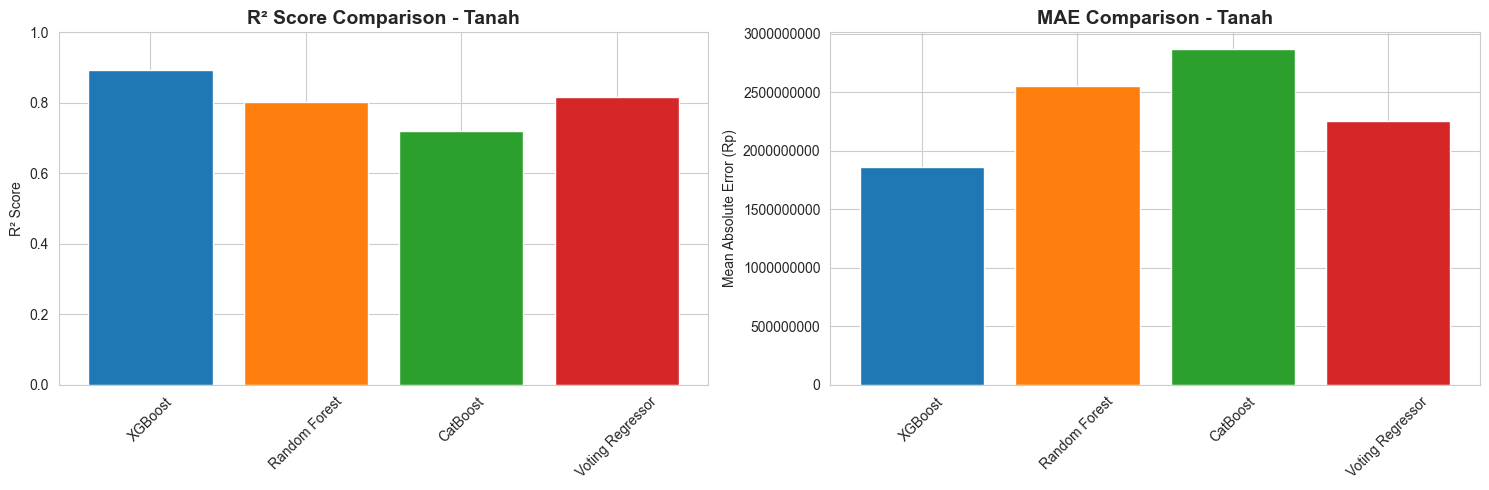

In [10]:
# Compare model performance - Tanah
tanah_results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'CatBoost', 'Voting Regressor'],
    'R² Score': [r2_xgb_tanah, r2_rf_tanah, r2_cat_tanah, r2_voting_tanah],
    'MAE': [mae_xgb_tanah, mae_rf_tanah, mae_cat_tanah, mae_voting_tanah]
})

print("📊 Model Performance Comparison - Tanah:")
display(tanah_results.sort_values('R² Score', ascending=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
axes[0].bar(tanah_results['Model'], tanah_results['R² Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_title('R² Score Comparison - Tanah', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(tanah_results['Model'], tanah_results['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('MAE Comparison - Tanah', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean Absolute Error (Rp)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## 6. Model Training - Bangunan

In [11]:
# Prepare data for training
X_bangunan = bangunan_processed.drop('Nilai Jual Bangunan (Rp)', axis=1)
y_bangunan = bangunan_processed['Nilai Jual Bangunan (Rp)']

# Split data
X_train_bangunan, X_test_bangunan, y_train_bangunan, y_test_bangunan = train_test_split(
    X_bangunan, y_bangunan, test_size=0.2, random_state=42
)

print(f"📊 Data Split - Bangunan:")
print(f"   Training set: {len(X_train_bangunan)} samples")
print(f"   Test set: {len(X_test_bangunan)} samples")
print(f"   Features: {len(X_bangunan.columns)}")

📊 Data Split - Bangunan:
   Training set: 800 samples
   Test set: 200 samples
   Features: 14


In [ ]:
# Initialize models for Bangunan with optimized hyperparameters
print("🚀 Training Models for Bangunan...\n")

# 1. XGBoost - Optimized
print("1️⃣ Training XGBoost (Optimized)...")
xgb_bangunan = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_bangunan.fit(X_train_bangunan, y_train_bangunan)
y_pred_xgb_bangunan = xgb_bangunan.predict(X_test_bangunan)
r2_xgb_bangunan = r2_score(y_test_bangunan, y_pred_xgb_bangunan)
mae_xgb_bangunan = mean_absolute_error(y_test_bangunan, y_pred_xgb_bangunan)
rmse_xgb_bangunan = np.sqrt(mean_squared_error(y_test_bangunan, y_pred_xgb_bangunan))
print(f"   R² Score: {r2_xgb_bangunan:.4f}")
print(f"   MAE: Rp {mae_xgb_bangunan:,.0f}")
print(f"   RMSE: Rp {rmse_xgb_bangunan:,.0f}\n")

# 2. Random Forest - Optimized
print("2️⃣ Training Random Forest (Optimized)...")
rf_bangunan = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_bangunan.fit(X_train_bangunan, y_train_bangunan)
y_pred_rf_bangunan = rf_bangunan.predict(X_test_bangunan)
r2_rf_bangunan = r2_score(y_test_bangunan, y_pred_rf_bangunan)
mae_rf_bangunan = mean_absolute_error(y_test_bangunan, y_pred_rf_bangunan)
rmse_rf_bangunan = np.sqrt(mean_squared_error(y_test_bangunan, y_pred_rf_bangunan))
print(f"   R² Score: {r2_rf_bangunan:.4f}")
print(f"   MAE: Rp {mae_rf_bangunan:,.0f}")
print(f"   RMSE: Rp {rmse_rf_bangunan:,.0f}\n")

# 3. CatBoost - Optimized
print("3️⃣ Training CatBoost (Optimized)...")
catboost_bangunan = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)
catboost_bangunan.fit(X_train_bangunan, y_train_bangunan)
y_pred_cat_bangunan = catboost_bangunan.predict(X_test_bangunan)
r2_cat_bangunan = r2_score(y_test_bangunan, y_pred_cat_bangunan)
mae_cat_bangunan = mean_absolute_error(y_test_bangunan, y_pred_cat_bangunan)
rmse_cat_bangunan = np.sqrt(mean_squared_error(y_test_bangunan, y_pred_cat_bangunan))
print(f"   R² Score: {r2_cat_bangunan:.4f}")
print(f"   MAE: Rp {mae_cat_bangunan:,.0f}")
print(f"   RMSE: Rp {rmse_cat_bangunan:,.0f}\n")

# 4. Voting Regressor with weighted voting
print("4️⃣ Training Voting Regressor (Weighted Ensemble)...")
voting_bangunan = VotingRegressor(
    estimators=[
        ('xgb', xgb_bangunan),
        ('rf', rf_bangunan),
        ('cat', catboost_bangunan)
    ],
    weights=[0.35, 0.30, 0.35]  # Balanced weights
)
voting_bangunan.fit(X_train_bangunan, y_train_bangunan)
y_pred_voting_bangunan = voting_bangunan.predict(X_test_bangunan)
r2_voting_bangunan = r2_score(y_test_bangunan, y_pred_voting_bangunan)
mae_voting_bangunan = mean_absolute_error(y_test_bangunan, y_pred_voting_bangunan)
rmse_voting_bangunan = np.sqrt(mean_squared_error(y_test_bangunan, y_pred_voting_bangunan))
print(f"   R² Score: {r2_voting_bangunan:.4f}")
print(f"   MAE: Rp {mae_voting_bangunan:,.0f}")
print(f"   RMSE: Rp {rmse_voting_bangunan:,.0f}\n")

print("✅ All models trained successfully!")
print(f"\n📊 Best Model: Voting Regressor with R² = {r2_voting_bangunan:.4f}")

🚀 Training Models for Bangunan...

1️⃣ Training XGBoost...
   R² Score: 0.9918
   MAE: Rp 1,431,829

2️⃣ Training Random Forest...
   R² Score: 0.9895
   MAE: Rp 1,515,312

3️⃣ Training CatBoost...
   R² Score: 0.9856
   MAE: Rp 1,964,812

4️⃣ Training Voting Regressor...
   R² Score: 0.9910
   MAE: Rp 1,298,597

✅ All models trained successfully!


📊 Model Performance Comparison - Bangunan:


,Model,R² Score,MAE
0,XGBoost,0.991802,1.431829e+06
3,Voting Regressor,0.990958,1.298597e+06
1,Random Forest,0.989464,1.515312e+06
2,CatBoost,0.985588,1.964812e+06


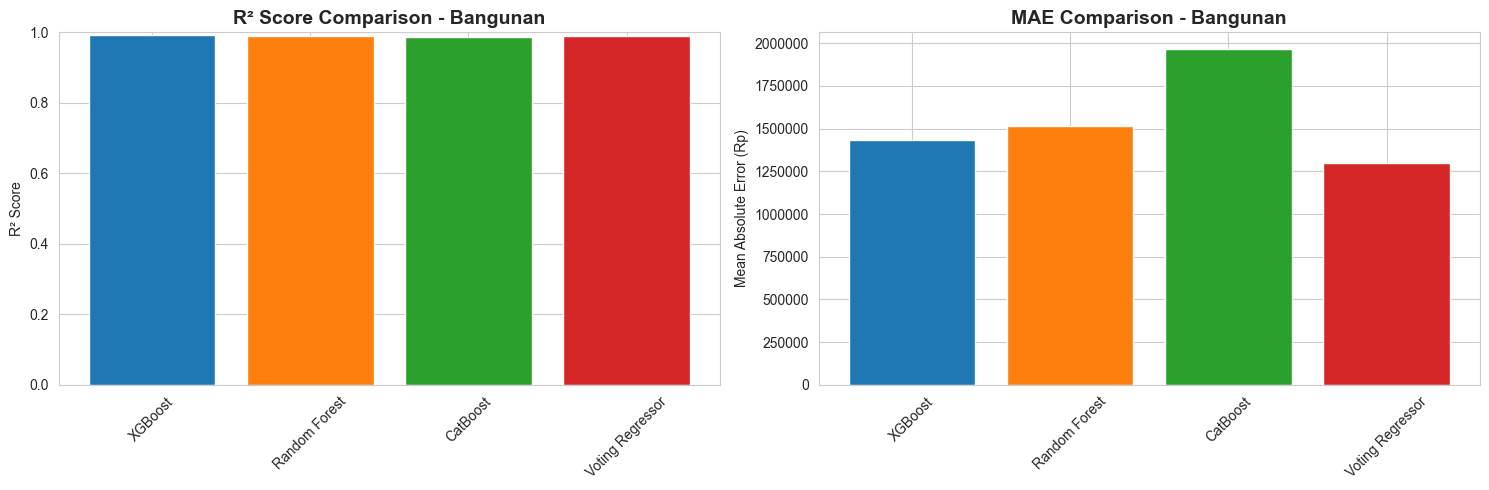

In [13]:
# Compare model performance - Bangunan
bangunan_results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'CatBoost', 'Voting Regressor'],
    'R² Score': [r2_xgb_bangunan, r2_rf_bangunan, r2_cat_bangunan, r2_voting_bangunan],
    'MAE': [mae_xgb_bangunan, mae_rf_bangunan, mae_cat_bangunan, mae_voting_bangunan]
})

print("📊 Model Performance Comparison - Bangunan:")
display(bangunan_results.sort_values('R² Score', ascending=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
axes[0].bar(bangunan_results['Model'], bangunan_results['R² Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_title('R² Score Comparison - Bangunan', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(bangunan_results['Model'], bangunan_results['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('MAE Comparison - Bangunan', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean Absolute Error (Rp)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

📊 Top 10 Important Features - Tanah:


,Feature,Importance
2,Luas Tanah (M²),0.644216
0,Kecamatan,0.165728
6,Kepadatan_Penduduk,0.099355
3,Jenis Zona,0.072142
5,Tingkat Keamanan,0.008756
1,Sertifikat,0.003922
4,Aksesibilitas,0.003281
7,Jarak ke Pusat Kota (km),0.002599


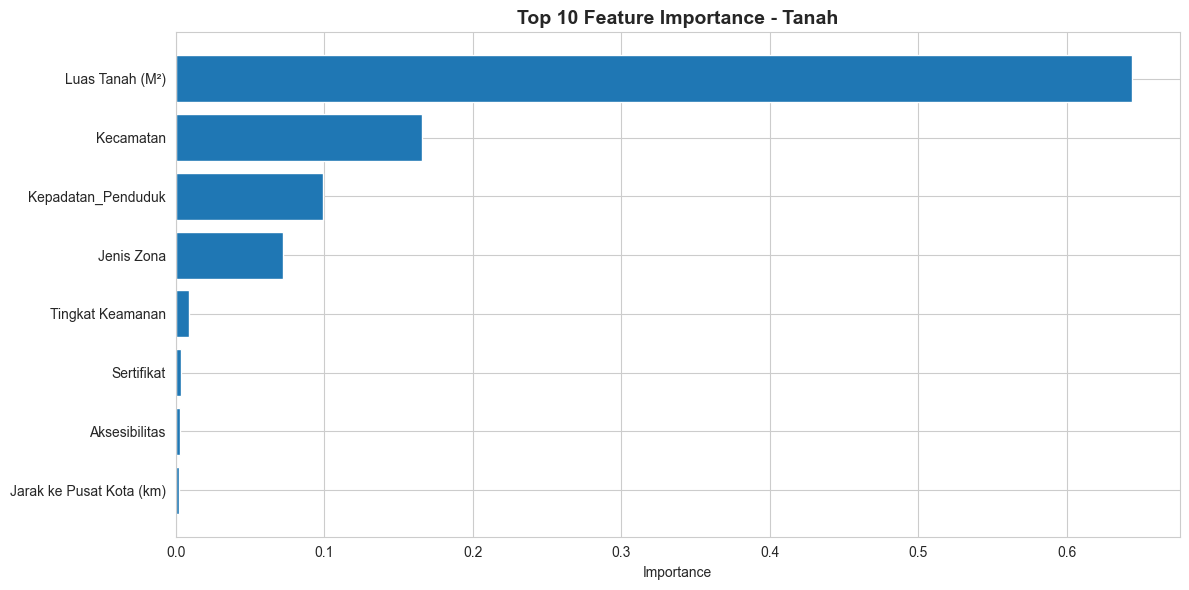

In [14]:
# Feature importance for Tanah (using best performing model)
feature_importance_tanah = pd.DataFrame({
    'Feature': X_tanah.columns,
    'Importance': voting_tanah.estimators_[0].feature_importances_  # XGBoost importance
}).sort_values('Importance', ascending=False)

print("📊 Top 10 Important Features - Tanah:")
display(feature_importance_tanah.head(10))

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_tanah.head(10)['Feature'], feature_importance_tanah.head(10)['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - Tanah', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 Top 10 Important Features - Bangunan:


,Feature,Importance
2,Luas Bangunan (m²),0.929432
9,NJOP (Rp/m²),0.063832
8,Hook,0.002477
3,Jumlah Lantai,0.002022
1,Luas Tanah (m²),0.000660
7,Daya Listrik (watt),0.000418
13,Usia Bangunan (tahun),0.000320
0,Kecamatan,0.000272
6,Sertifikat,0.000161
10,Jenis Zona,0.000097


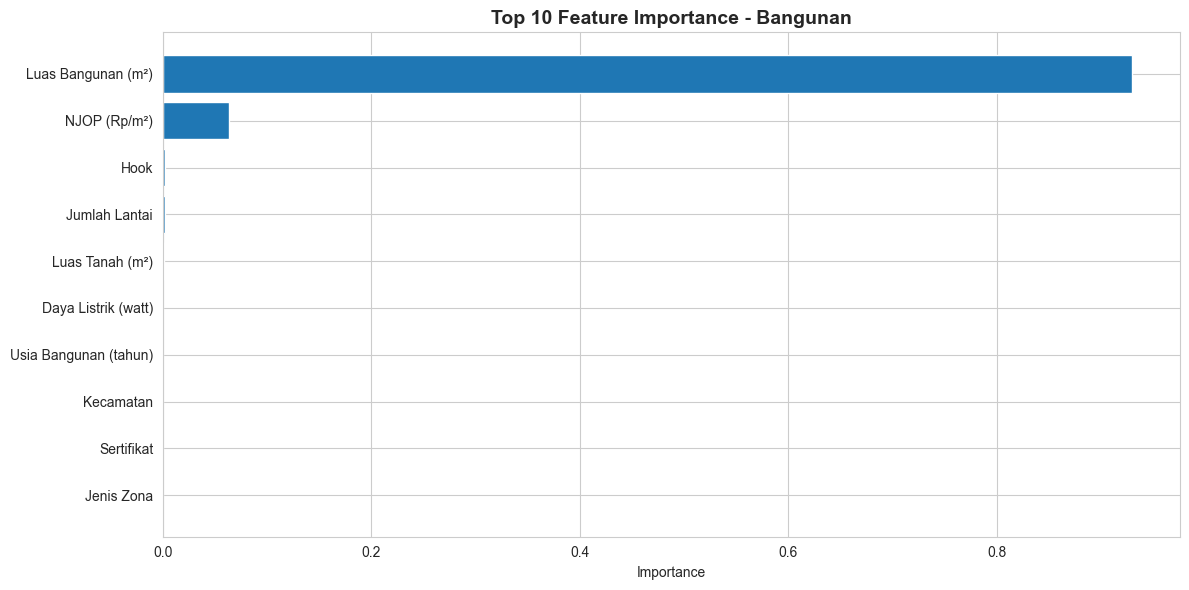

In [15]:
# Feature importance for Bangunan (using best performing model)
feature_importance_bangunan = pd.DataFrame({
    'Feature': X_bangunan.columns,
    'Importance': voting_bangunan.estimators_[0].feature_importances_  # XGBoost importance
}).sort_values('Importance', ascending=False)

print("📊 Top 10 Important Features - Bangunan:")
display(feature_importance_bangunan.head(10))

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_bangunan.head(10)['Feature'], feature_importance_bangunan.head(10)['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - Bangunan', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Model Evaluation - Prediction vs Actual

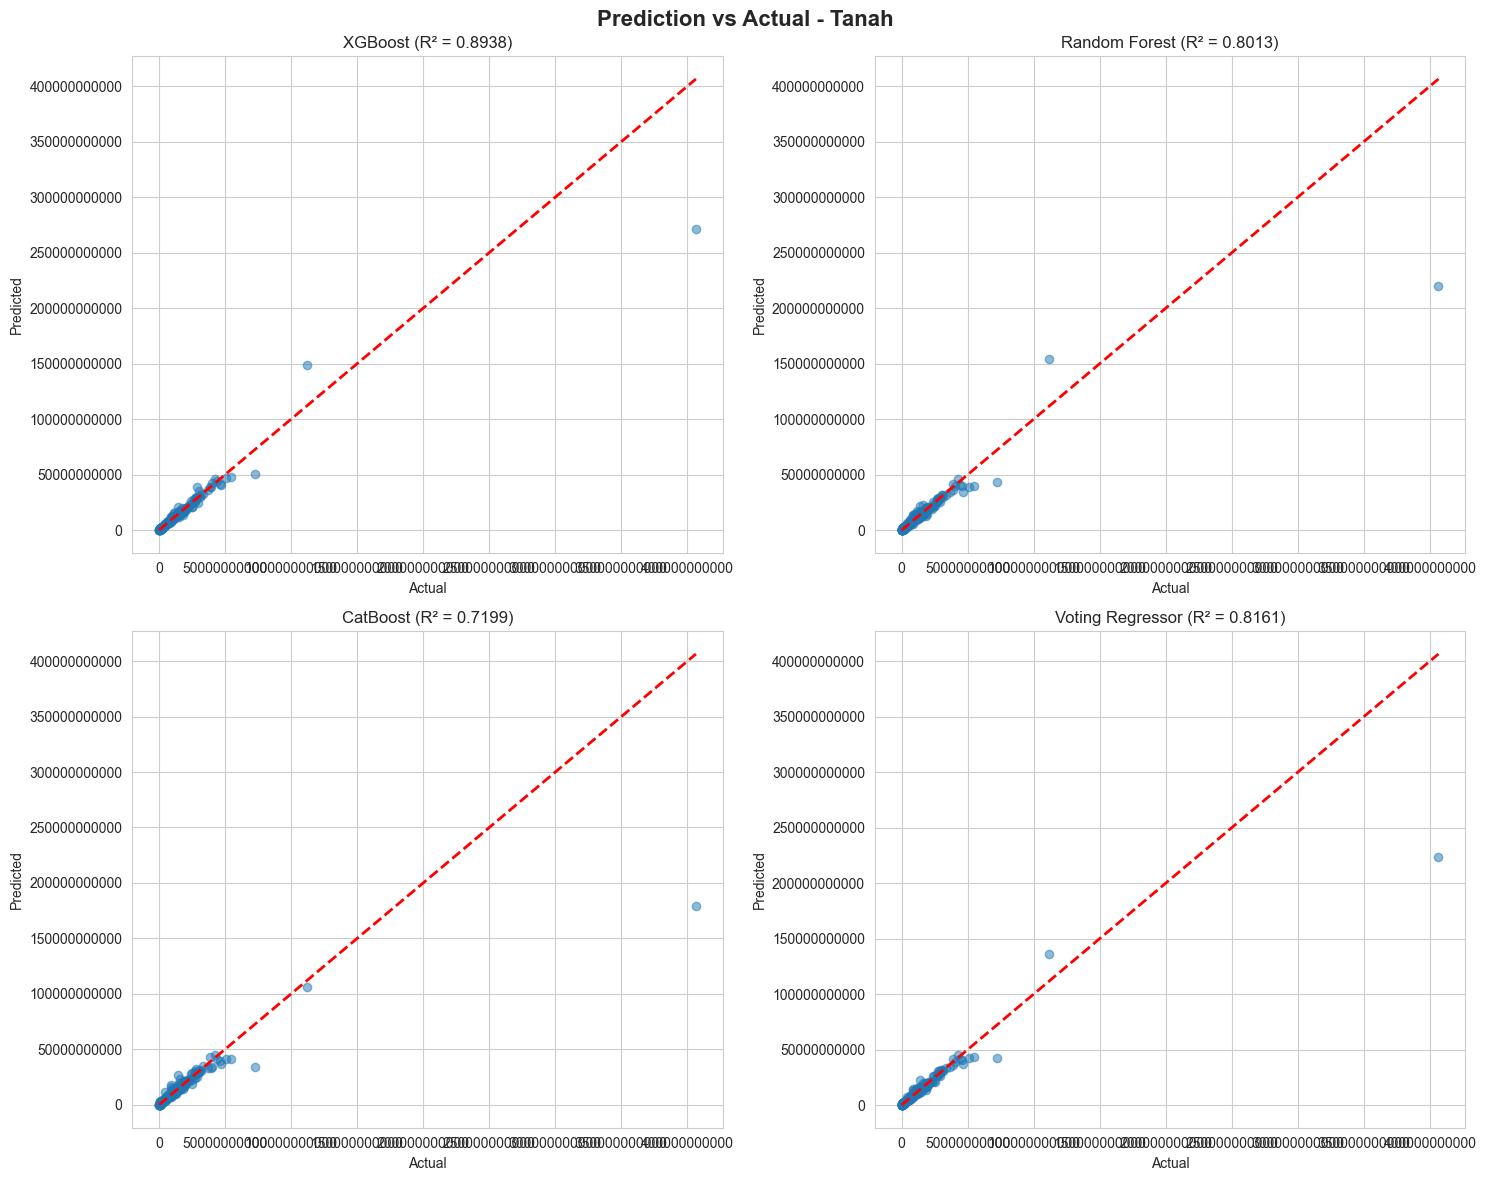

In [16]:
# Prediction vs Actual - Tanah
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Prediction vs Actual - Tanah', fontsize=16, fontweight='bold')

models_tanah = [
    ('XGBoost', y_pred_xgb_tanah, r2_xgb_tanah),
    ('Random Forest', y_pred_rf_tanah, r2_rf_tanah),
    ('CatBoost', y_pred_cat_tanah, r2_cat_tanah),
    ('Voting Regressor', y_pred_voting_tanah, r2_voting_tanah)
]

for idx, (name, pred, r2) in enumerate(models_tanah):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test_tanah, pred, alpha=0.5)
    ax.plot([y_test_tanah.min(), y_test_tanah.max()], [y_test_tanah.min(), y_test_tanah.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name} (R² = {r2:.4f})')
    ax.ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

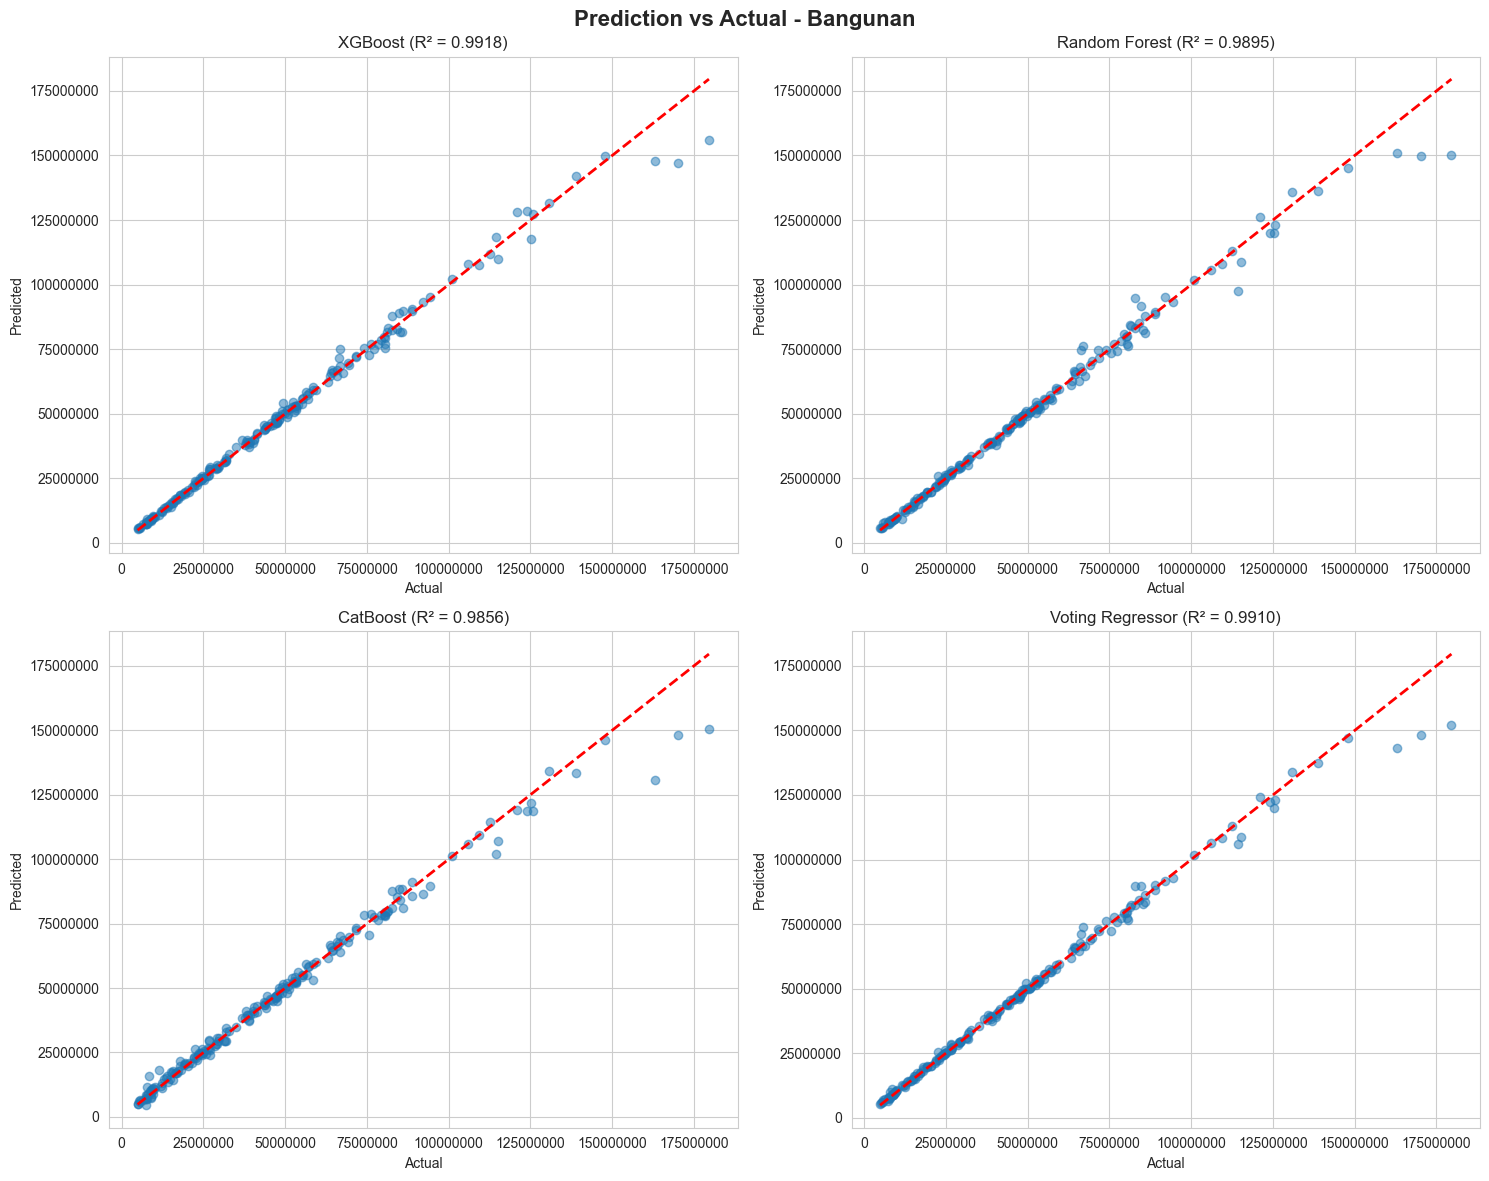

In [17]:
# Prediction vs Actual - Bangunan
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Prediction vs Actual - Bangunan', fontsize=16, fontweight='bold')

models_bangunan = [
    ('XGBoost', y_pred_xgb_bangunan, r2_xgb_bangunan),
    ('Random Forest', y_pred_rf_bangunan, r2_rf_bangunan),
    ('CatBoost', y_pred_cat_bangunan, r2_cat_bangunan),
    ('Voting Regressor', y_pred_voting_bangunan, r2_voting_bangunan)
]

for idx, (name, pred, r2) in enumerate(models_bangunan):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test_bangunan, pred, alpha=0.5)
    ax.plot([y_test_bangunan.min(), y_test_bangunan.max()], [y_test_bangunan.min(), y_test_bangunan.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name} (R² = {r2:.4f})')
    ax.ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

## 9. Save Models

In [18]:
# Create model directory if not exists
os.makedirs('../model/jual_tanah', exist_ok=True)
os.makedirs('../model/jual_bangunan', exist_ok=True)

print("💾 Saving models...\n")

# Save Tanah models
print("📦 Saving Tanah models...")
joblib.dump(voting_tanah, '../model/jual_tanah/voting_regressor.pkl')
joblib.dump(xgb_tanah, '../model/jual_tanah/xgboost.pkl')
joblib.dump(rf_tanah, '../model/jual_tanah/random_forest.pkl')
joblib.dump(catboost_tanah, '../model/jual_tanah/catboost.pkl')
joblib.dump(tanah_encoders, '../model/jual_tanah/label_encoders.pkl')
joblib.dump(list(X_tanah.columns), '../model/jual_tanah/feature_names.pkl')
print("   ✅ Tanah models saved")

# Save Bangunan models
print("\n📦 Saving Bangunan models...")
joblib.dump(voting_bangunan, '../model/jual_bangunan/voting_regressor.pkl')
joblib.dump(xgb_bangunan, '../model/jual_bangunan/xgboost.pkl')
joblib.dump(rf_bangunan, '../model/jual_bangunan/random_forest.pkl')
joblib.dump(catboost_bangunan, '../model/jual_bangunan/catboost.pkl')
joblib.dump(bangunan_encoders, '../model/jual_bangunan/label_encoders.pkl')
joblib.dump(list(X_bangunan.columns), '../model/jual_bangunan/feature_names.pkl')
print("   ✅ Bangunan models saved")

# Save model performance metrics
print("\n📊 Saving performance metrics...")
tanah_results.to_csv('../model/jual_tanah/model_performance.csv', index=False)
bangunan_results.to_csv('../model/jual_bangunan/model_performance.csv', index=False)
print("   ✅ Performance metrics saved")

print("\n✅ All models and metadata saved successfully!")
print("\n📁 Saved files:")
print("   Tanah: ../model/jual_tanah/")
print("   Bangunan: ../model/jual_bangunan/")

💾 Saving models...

📦 Saving Tanah models...
   ✅ Tanah models saved

📦 Saving Bangunan models...
   ✅ Bangunan models saved

📊 Saving performance metrics...
   ✅ Performance metrics saved

✅ All models and metadata saved successfully!

📁 Saved files:
   Tanah: ../model/jual_tanah/
   Bangunan: ../model/jual_bangunan/


## 10. Test Prediction Function

In [19]:
def predict_harga_jual_tanah(kecamatan, sertifikat, luas_tanah, jenis_zona, 
                              aksesibilitas, tingkat_keamanan, kepadatan_penduduk, 
                              jarak_ke_pusat):
    """
    Predict harga jual tanah based on input features
    """
    # Load model and encoders
    model = joblib.load('../model/jual_tanah/voting_regressor.pkl')
    encoders = joblib.load('../model/jual_tanah/label_encoders.pkl')
    feature_names = joblib.load('../model/jual_tanah/feature_names.pkl')
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Kecamatan': [kecamatan],
        'Sertifikat': [sertifikat],
        'Luas Tanah (M²)': [luas_tanah],
        'Jenis Zona': [jenis_zona],
        'Aksesibilitas': [aksesibilitas],
        'Tingkat Keamanan': [tingkat_keamanan],
        'Kepadatan_Penduduk': [kepadatan_penduduk],
        'Jarak ke Pusat Kota (km)': [jarak_ke_pusat]
    })
    
    # Encode categorical variables
    for col in ['Kecamatan', 'Sertifikat', 'Jenis Zona', 'Aksesibilitas', 'Tingkat Keamanan']:
        if col in encoders:
            input_data[col] = encoders[col].transform(input_data[col].astype(str))
    
    # Reorder columns to match training
    input_data = input_data[feature_names]
    
    # Predict
    prediction = model.predict(input_data)[0]
    
    return prediction

# Test prediction
print("🧪 Testing Tanah Prediction...\n")
test_prediction = predict_harga_jual_tanah(
    kecamatan='Gubeng',
    sertifikat='SHM',
    luas_tanah=500,
    jenis_zona='Komersial',
    aksesibilitas='Baik',
    tingkat_keamanan='tinggi',
    kepadatan_penduduk=123961,
    jarak_ke_pusat=5.0
)

print(f"Predicted Harga Jual Tanah: Rp {test_prediction:,.0f}")
print("\n✅ Prediction function working correctly!")

🧪 Testing Tanah Prediction...

Predicted Harga Jual Tanah: Rp 2,572,697,518

✅ Prediction function working correctly!


In [20]:
def predict_harga_jual_bangunan(kecamatan, sertifikat, luas_tanah, luas_bangunan,
                                 jenis_zona, kondisi_bangunan, jumlah_lantai,
                                 tahun_dibangun, aksesibilitas, tingkat_keamanan,
                                 kepadatan_penduduk, jarak_ke_pusat):
    """
    Predict harga jual bangunan based on input features
    """
    # Load model and encoders
    model = joblib.load('../model/jual_bangunan/voting_regressor.pkl')
    encoders = joblib.load('../model/jual_bangunan/label_encoders.pkl')
    feature_names = joblib.load('../model/jual_bangunan/feature_names.pkl')
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Kecamatan': [kecamatan],
        'Sertifikat': [sertifikat],
        'Luas Tanah (M²)': [luas_tanah],
        'Luas Bangunan (M²)': [luas_bangunan],
        'Jenis Zona': [jenis_zona],
        'Kondisi Bangunan': [kondisi_bangunan],
        'Jumlah Lantai': [jumlah_lantai],
        'Tahun Dibangun': [tahun_dibangun],
        'Aksesibilitas': [aksesibilitas],
        'Tingkat Keamanan': [tingkat_keamanan],
        'Kepadatan_Penduduk': [kepadatan_penduduk],
        'Jarak ke Pusat Kota (km)': [jarak_ke_pusat]
    })
    
    # Encode categorical variables
    for col in ['Kecamatan', 'Sertifikat', 'Jenis Zona', 'Kondisi Bangunan', 'Aksesibilitas', 'Tingkat Keamanan']:
        if col in encoders:
            input_data[col] = encoders[col].transform(input_data[col].astype(str))
    
    # Reorder columns to match training
    input_data = input_data[feature_names]
    
    # Predict
    prediction = model.predict(input_data)[0]
    
    return prediction

# Test prediction
print("🧪 Testing Bangunan Prediction...\n")
test_prediction_bangunan = predict_harga_jual_bangunan(
    kecamatan='Gubeng',
    sertifikat='SHM',
    luas_tanah=300,
    luas_bangunan=250,
    jenis_zona='Komersial',
    kondisi_bangunan='Baik',
    jumlah_lantai=2,
    tahun_dibangun=2015,
    aksesibilitas='Baik',
    tingkat_keamanan='tinggi',
    kepadatan_penduduk=123961,
    jarak_ke_pusat=5.0
)

print(f"Predicted Harga Jual Bangunan: Rp {test_prediction_bangunan:,.0f}")
print("\n✅ Prediction function working correctly!")

🧪 Testing Bangunan Prediction...



ValueError: y contains previously unseen labels: 'Baik'

## 11. Summary & Conclusions

In [ ]:
print("="*80)
print("📊 SUMMARY - PREDIKSI HARGA JUAL ASET")
print("="*80)

print("\n🏆 BEST PERFORMING MODELS:\n")

# Tanah
best_tanah = tanah_results.loc[tanah_results['R² Score'].idxmax()]
print(f"TANAH: {best_tanah['Model']}")
print(f"   R² Score: {best_tanah['R² Score']:.4f}")
print(f"   MAE: Rp {best_tanah['MAE']:,.0f}")

# Bangunan
best_bangunan = bangunan_results.loc[bangunan_results['R² Score'].idxmax()]
print(f"\nBANGUNAN: {best_bangunan['Model']}")
print(f"   R² Score: {best_bangunan['R² Score']:.4f}")
print(f"   MAE: Rp {best_bangunan['MAE']:,.0f}")

print("\n" + "="*80)
print("📁 SAVED MODELS:")
print("="*80)
print("\n✅ Tanah Models:")
print("   - Voting Regressor (Ensemble)")
print("   - XGBoost")
print("   - Random Forest")
print("   - CatBoost")
print("   - Label Encoders")
print("   - Feature Names")

print("\n✅ Bangunan Models:")
print("   - Voting Regressor (Ensemble)")
print("   - XGBoost")
print("   - Random Forest")
print("   - CatBoost")
print("   - Label Encoders")
print("   - Feature Names")

print("\n" + "="*80)
print("🎯 NEXT STEPS:")
print("="*80)
print("\n1. Integrate models into Flask backend (routes_prediction.py)")
print("2. Create API endpoints for prediction")
print("3. Add prediction form in admin dashboard")
print("4. Test predictions with various input scenarios")
print("5. Monitor model performance in production")
print("6. Retrain models periodically with new data")

print("\n" + "="*80)
print("✨ NOTEBOOK EXECUTION COMPLETED SUCCESSFULLY!")
print("="*80)